# TMDB Network Analysis


## Setup

In [13]:
import pandas as pd
from itertools import combinations, chain
import ast
import networkx as nx
from matplotlib import pyplot as plt
import json

In [14]:
create_tvnamedf = False

if create_tvnamedf:
    
    file_path = r'tv_series_ids_05_25_2024.json'

    json_objects = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            try:
                json_object = json.loads(line.strip())
                json_objects.append(json_object)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line: {line.strip()}")
                print(f"Error message: {e}")



    tvname_df_dict = {'id': [], 'original_name': [], 'popularity': []}

    for obj in json_objects:
        tvname_df_dict['id'].append(obj['id'])
        tvname_df_dict['original_name'].append(obj['original_name'])
        tvname_df_dict['popularity'].append(obj['popularity'])

    tvname_df = pd.DataFrame(tvname_df_dict)
    tvname_df.to_csv('tv_lookup.csv', index = False)

In [15]:
composername_lookup = pd.read_csv("composer_lookup.csv")
directorname_lookup = pd.read_csv("director_lookup.csv")
main_df = pd.read_csv("main_df.csv")

In [16]:
# Checking the types of the elements in the 'composer_roles' column
print(main_df['composer_roles'].apply(type).unique())


[<class 'str'>]


## Data Processing

In [17]:
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

In [18]:
main_df['composer_roles'] = main_df['composer_roles'].apply(safe_literal_eval) # the dictionary was read in a string, we want it as a dictionary
main_df['composers'] = main_df['composers'].apply(safe_literal_eval)
main_df['directors'] = main_df['directors'].apply(safe_literal_eval)

In [19]:
print(main_df.head(100))

     tv_id                                          composers  \
0   126200                                                 []   
1    34919                                                 []   
2   126201                                                 []   
3    34937                                                 []   
4   128925                                                 []   
..     ...                                                ...   
95   66303                                                 []   
96   34910                                                 []   
97  128922                                                 []   
98  126225                                                 []   
99   66310  [1901937, 937927, 1408706, 1901938, 1901937, 1...   

                                            directors  \
0                                                  []   
1                                                  []   
2                                               

In [20]:
print(composername_lookup.head())

   composer_id    composer_name  popularity
0        16463   Howard Goodall       5.886
1      1150062  Kurt von Ruffin       1.266
2      1505059     Yuki Hayashi       7.762
3      3667327     Ulaş Özdemir       0.518
4      3152969     Milind Borde       0.005


In [21]:
print(directorname_lookup.head())

   director_id    director_name  popularity
0       203039   Anders Lenhoff       1.921
1       145522      Aydın Bulut       4.085
2      1794185   Kirill Kapitsa       2.912
3      2117587  Sergey Malyugov       1.712
4      2117571    Pavel Simonov       0.545


## Edgelist Creation

In [22]:
composer_connections = []
linking_ids = []

# Parse dataframe to create sets of composers for each tv_id
for index, row in main_df.iterrows():
    tv_id = row['tv_id']
    composers = row['composers']
    composer_roles = row['composer_roles']

    # For each pair of composers in the same tv_id, generate an edge and an edge attribute of how they are linked
    if len(composers) > 1:
        for pair in combinations(composers, 2):
            composer_connections.append(tuple(sorted(pair)))
            linking_ids.append(tv_id)

edgelist_df = pd.DataFrame(composer_connections, columns=['composer1', 'composer2'])
edgelist_df['linking_id'] = linking_ids

In [23]:
#edgelist_df.to_csv('edgelist_df.csv', index = False)

## More data exploration

In [24]:
unique_composer_jobs = set()

# Iterate through main_data and collect all unique composer roles
for entry in list(main_df['composer_roles']):
    for job_title in entry.values():
        unique_composer_jobs.add(job_title)
        
print(unique_composer_jobs)

{'Music Programmer', 'Additional Music Supervisor', 'Original Music Composer', 'Music Supervisor', 'Supervising Music Editor', 'Music Co-Supervisor', 'Music Supervision Assistant', 'Music Director', 'Musician', 'Music Editor', 'Executive Music Producer', 'Music Producer', 'Music', 'Additional Music', 'Main Title Theme Composer', 'Music Coordinator', 'Musical Casting', 'Music Arranger', 'Musical', 'Temp Music Editor', 'Music Sound Design and Processing', 'Assistant Music Supervisor', 'Music Score Producer', 'Music Consultant'}


In [25]:
sorted_edgelist_df = edgelist_df.sort_values(by='composer1')
print(sorted_edgelist_df)

       composer1  composer2  linking_id
72073         37       2722        1026
72047         37       3535        1026
69386         37    4115581        2391
69261         37      24954        2391
1628          37      20897         509
...          ...        ...         ...
64032    4721744    4721753       93539
64029    4721753    4721754       93539
64028    4721753    4721755       93539
64035    4721754    4721755       93539
64204    4733170    4733172      254939

[81345 rows x 3 columns]


In [26]:
edgelist_df[(edgelist_df['composer1'] == 4721754) & (edgelist_df['composer2'] == 4721755)]


,composer1,composer2,linking_id
64035,4721754,4721755,93539


In [64]:
edgelist_df = edgelist_df[edgelist_df['composer1'] != edgelist_df['composer2']] # removing loop edges
edgelist_df = edgelist_df.drop_duplicates() # removing duplicate edges
edgelist_df = edgelist_df.drop_duplicates(subset = ['composer1', 'composer2'])

In [65]:
edgelist_df.to_csv('edgelist_df.csv', index = False)

In [29]:
main_df[main_df['tv_id'] == 65494] # The Crown tv show

,tv_id,composers,directors,composer_roles,composer_list_length
22584,65494,"[4379850, 947, 2593, 2593, 1746704, 139904, 92...","[49345, 52530, 1406847, 18830, 72845, 1168680,...","{4379850: 'Additional Music', 947: 'Main Title...",8


In [30]:
import pprint

composer_roles = main_df[main_df['tv_id'] == 65494]['composer_roles'].iloc[0]

pprint.pprint(composer_roles)

composer_roles = main_df[main_df['tv_id'] == 65494]['composers'].iloc[0]

pprint.pprint(composer_roles) # printing out the crew for The Crown tv show

{947: 'Main Title Theme Composer',
 2593: 'Original Music Composer',
 139904: 'Original Music Composer',
 929145: 'Music',
 1746704: 'Music Supervisor',
 4379850: 'Additional Music'}
[4379850, 947, 2593, 2593, 1746704, 139904, 929145, 929145]


In [31]:
composer_ids = main_df[main_df['tv_id'] == 65494]['composers'].iloc[0]

pprint.pprint(composer_ids)

[4379850, 947, 2593, 2593, 1746704, 139904, 929145, 929145]


## Graph Setup

In [32]:
edge_list = [(row.composer1, row.composer2, {'linking_id': row.linking_id}) for row in edgelist_df.itertuples(index=False)]
G = nx.Graph()
G.add_edges_from(edge_list) # graph creation

## EDA

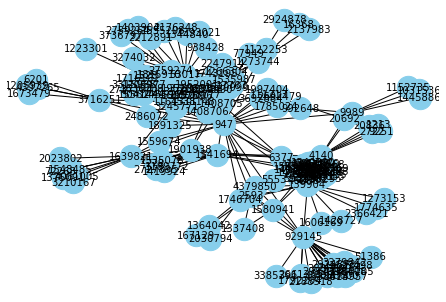

In [33]:
# Draw the Hans Zimmer neighbourhood within a 2 degree radius

neighborhood = nx.ego_graph(G, 947, radius=2)

pos = nx.spring_layout(neighborhood)  # Positions for all nodes
nx.draw(neighborhood, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=10, font_color='black')


In [34]:
node_degrees = G.degree()
highest_degree_node = max(node_degrees, key=lambda x: x[1])[0]
print(f"The node with the highest degree in the graph is: {highest_degree_node}")
print(G.degree(17409))


The node with the highest degree in the graph is: 48235
263


In [35]:
composername_lookup[composername_lookup['composer_id'] == highest_degree_node]

,composer_id,composer_name,popularity
2344,48235,Robert Schulte-Hemming,1.339


In [36]:
edge_labels = []
for edge in G.edges(data=True):
    if edge[0] == highest_degree_node or edge[1] == highest_degree_node:
        label = edge[2].get('linking_id', None)
        if label:
            edge_labels.append(label)

print(f"Edge labels connected to the highest degree node {highest_degree_node}: {edge_labels}")


Edge labels connected to the highest degree node 48235: [21116, 3034, 3034, 3034, 3034, 3034, 3034, 3034, 3034, 62325, 62325, 3034, 62325, 3034, 62072, 3034, 3034, 14210, 3034, 3034, 14210, 3034, 3034, 3034, 14210, 3034, 14210, 3034, 14210, 14210, 14210, 14210, 14210, 3034, 3034, 14210, 3034, 14210, 14210, 3034, 14210, 3034, 3034, 3034, 3034, 14210, 3034, 14210, 14210, 14210, 14210, 3034, 14210, 14210, 14210, 14210, 14210, 3034, 3034, 14210, 14210, 3034, 3034, 14210, 14210, 14210, 3034, 3034, 14210, 14210, 14210, 14210, 14210, 3034, 14210, 3034, 14210, 14210, 14210, 14210, 14210, 14210, 3034, 14210, 14210, 14210, 14210, 14210, 14210, 14210, 14210, 3034, 14210, 14210, 14210, 14210, 3034, 3034, 14210, 3034, 3034, 14210, 14210, 14210, 14210, 3034, 14210, 14210, 14210, 14210, 3034, 3034, 3034, 14210, 14210, 14210, 3034, 14210, 3034, 14210, 14210, 14210, 14210, 3034, 14210, 3034, 14210, 3034, 14210, 14210, 3034, 14210, 14210, 3034, 3034, 3034, 3034, 3034, 3034, 3034, 3034, 3034, 3034, 3034,

TV Show 3034 seems to have a lot of music crew members

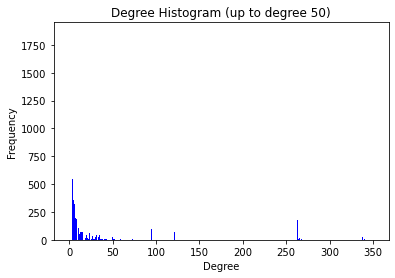

In [37]:
degree_freq = nx.degree_histogram(G)
max_degree = len(degree_freq)
plt.bar(range(max_degree), degree_freq[:max_degree], width=0.8, color='b')

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Histogram (up to degree 50)')

plt.show()

In [38]:
node_degrees = G.degree()
highest_degree_node = max(node_degrees, key=lambda x: x[1])[0]

In [39]:
def zimmer_number_path(composer, target=947):
    # Check if both the source and target nodes exist in the graph
    if composer not in G.nodes:
        raise nx.NodeNotFound(f"Source node {composer} is not in the graph")
    if target not in G.nodes:
        raise nx.NodeNotFound(f"Target node {target} is not in the graph")
    
    # Find shortest path
    try:
        path = nx.shortest_path(G, source=composer, target=target)
        return path
    except nx.NetworkXNoPath:
        print(f"No path exists between {composer} and {target}")
        return None

# Testing
shortest_path_nodes = zimmer_number_path(48235)
if shortest_path_nodes:
    print("Shortest path nodes:", shortest_path_nodes)
else:
    print("No path found or nodes do not exist in the graph.")


Shortest path nodes: [48235, 1023809, 139904, 947]


In [40]:
print(zimmer_number_path(48235))

[48235, 1023809, 139904, 947]


In [41]:
pathnodes = zimmer_number_path(48235)

In [42]:
subgraph = G.subgraph(pathnodes)

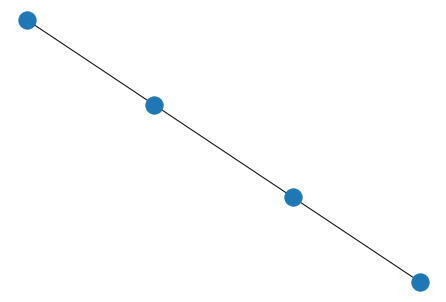

In [43]:
nx.draw(subgraph) # drawing the path found above

## Finding all nodes which are in some way linked to Hans Zimmer

In [44]:
zimmerneighborhood = nx.ego_graph(G, 947, radius=50)

In [46]:
list(zimmerneighborhood.nodes)

[24583,
 1703944,
 1728522,
 32779,
 1556494,
 1376277,
 491541,
 1171480,
 90138,
 2162717,
 3383326,
 229410,
 37,
 1867818,
 2613295,
 1376311,
 1294394,
 2580538,
 2383935,
 1523778,
 1155140,
 1597510,
 1015883,
 2089035,
 32845,
 1597519,
 1597521,
 1433681,
 3154003,
 4563029,
 4104278,
 4104280,
 32857,
 4104281,
 2162780,
 1327197,
 2244701,
 1900639,
 4104286,
 1409124,
 2957414,
 1302631,
 2506855,
 3383401,
 3383404,
 3383405,
 3383406,
 1597551,
 2105455,
 3154031,
 117,
 122,
 1515643,
 983164,
 2654331,
 1982590,
 8320,
 1261697,
 49285,
 3170437,
 3088518,
 16520,
 1515657,
 3612808,
 1515661,
 24717,
 1515664,
 65681,
 49303,
 1491096,
 153,
 1261721,
 2195611,
 2326683,
 3088537,
 4120736,
 4546722,
 3989667,
 2326692,
 1515685,
 2326693,
 2326694,
 2326691,
 1327273,
 2498724,
 1515692,
 1106092,
 57518,
 82092,
 4087983,
 49330,
 3825846,
 186,
 1597627,
 1515713,
 1179841,
 195,
 1392836,
 1548485,
 1368260,
 1515719,
 1368258,
 3399882,
 3399883,
 3399884,
 268718

In [48]:
zimdict = {'nodes': list(zimmerneighborhood.nodes)}

In [49]:
zimmer_eligible = pd.DataFrame(zimdict)

In [51]:
zimmer_eligible.to_csv('zimmer_eligible.csv', index = False)

In [73]:
test_sub.edges(data = True)

EdgeDataView([(2593, 947, {'linking_id': 65494}), (2593, 2593, {'linking_id': 65494}), (2593, 1580941, {'linking_id': 71769}), (1484588, 1191567, {'linking_id': 75262}), (1580941, 1191567, {'linking_id': 79680}), (947, 947, {'linking_id': 116156})])